### Figure 2 : 

In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.extend(['/home/nkinsky/Documents/GitHub/NeuroPy'])
sys.path.extend(['/home/nkinsky/Documents/GitHubPrivate/pythonprogs/DataPaths/'])
    
import matplotlib.pyplot as plt
import numpy as np
import subjects
import pandas as pd
import seaborn as sns
import matplotlib.colors as mcolors
from neuropy.plotting import Fig
from scipy import stats
from plotters import Plotter, get_nsd_vs_sd_df
from neuropy import plotting
from stats_utils import get_bootstrap_prob, get_bootstrap_prob_paired

grpdata = subjects.GroupData()

### 2A: Firing Rate example plots
Code copied from `sd_firing_dynamics_examples.ipynb` and adjusted to color SD epochs correctly

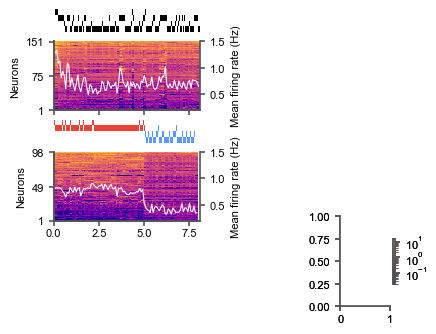

In [2]:
fig = plotting.Fig(nrows=8, ncols=9, constrained_layout=False)
subfig = fig.add_subfigure(fig.gs[:2, 1:3])
axs = subfig.subplots(
    4, 1, sharex=True, gridspec_kw=dict(height_ratios=[1, 3, 1, 3])
)

combine_wake = False
state_bin_size = 30  # seconds

sessions = subjects.nsd.ratUday2 + subjects.sd.ratUday4
# sessions = subjects.nsd.ratSday2 + subjects.sd.ratSday3

for s, sess in enumerate(sessions):
    neurons = sess.neurons_stable.get_neuron_type(["pyr", "inter"])
    mean_frate = neurons.firing_rate
    neurons = neurons[np.argsort(mean_frate)]

    pre = sess.paradigm["pre"].flatten()
    maze = sess.paradigm["maze"].flatten()
    post = sess.paradigm["post"].flatten()

    pre = [np.max([pre[1] - 3600, pre[0]]), pre[1]]
    post1 = [post[0], post[0] + 8 * 3600]

    ax = axs[2 * s]

    # Change resolution
    states = sess.brainstates.time_slice(*post1)
    time0 = states.starts[0]
    if state_bin_size > 1:
        states = states.resample_labeled_epochs(state_bin_size, t_start=time0, t_stop=states.stops[-1], merge_neighbors=True)
        bin_append = f"_statebin{state_bin_size}"
        
    if combine_wake: # Combine wake states
        wk_states = states.label_slice(["AW", "QW"]).set_labels("WK").merge_neighbors()
        labels_order = ["NREM", "REM", "WK"]
    else: # Keep states split
        wk_states = states.label_slice(["AW", "QW"])
        labels_order = ["NREM", "REM", "QW", "AW"]
    slp_states = states.label_slice(["NREM", "REM"])
    all_states = slp_states + wk_states
    # Plot hypnogram
    sd_color = subjects.colors_sd(1)[1]
    rs_color = subjects.colors_rs(1)[0]
    grp = "NSD" if ("NSD" in str(sessions[s])) else "SD"
    colors = "k" if grp == "NSD" else {"SD": sd_color, "RS": rs_color}
    colorby = "label" if grp == "NSD" else "exp_stage"
    if grp == "SD":
        exp_stage = np.ones_like(all_states.labels)
        exp_stage[all_states.starts < (time0 + 5 * 3600)] = "SD"
        exp_stage[all_states.starts >= (time0 + 5 * 3600)] = "RS"
        all_states = all_states.add_column("exp_stage", exp_stage)
    plotting.plot_epochs(
        all_states,
        ax=ax,
        labels_order=labels_order,
        colors=colors,
        colorby=colorby,
        # colors=k,
        collapsed=False,
    )
    # plotting.plot_epochs(
    #     sess.brainstates.time_slice(*post1),
    #     ax=ax,
    #     labels_order=["NREM", "REM", "QW", "AW"],
    #     colors=subjects.colors_sleep,
    # )
    ax.set_axis_off()

    for i, ntype in enumerate(["pyr"]):
        binspk = (
            neurons.get_neuron_type(ntype)
            .time_slice(*post1)
            .get_binned_spiketrains(bin_size=5 * 60)
        )
        n_neurons = binspk.n_neurons

        if ntype=='pyr':
            norm=mcolors.LogNorm(0.02, 15, clip=True)
        if ntype == 'inter':
            norm=mcolors.LogNorm(10, 40, clip=True)


        ax = axs[2 * s + i + 1]
        im = ax.pcolormesh(
            binspk.time + 2.5 * 60,
            np.arange(binspk.n_neurons) + 1,
            binspk.firing_rate,
            cmap="plasma",
            norm=norm,
            rasterized=True,
        )
        ax.set_yticks([1, n_neurons // 2, n_neurons])
        ax.set_ylabel("Neurons")
        xticks = np.arange(post1[0], post1[1], 2.5 * 3600)
        ax.set_xticks(xticks, (xticks - post1[0]) / 3600)

        cax = fig.subplot(fig.gs[1, 4])
        plt.colorbar(im, ax=cax, shrink=0.5)

        ax = ax.twinx()
        ax.plot(binspk.time, np.mean(binspk.firing_rate, axis=0), "w", lw=0.8)
        ax.set_ylim(0.2, 1.5)
        ax.set_ylabel("Mean firing rate (Hz)")
        fig.toggle_spines(ax, sides=["right"], keep=True)

        # ax.set_facecolor("black")

fig.savefig(subjects.figpath_sd/'frate_pyr_example_splitwake_30sbin', format="svg", dpi=300)

### 2B-C: Firing rates


pyr NSD stats:
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       #: 2.50e-02 < p <= 5.00e-02
       *: 5.00e-03 < p <= 2.50e-02
      **: 5.00e-04 < p <= 5.00e-03
     ***: p <= 5.00e-04

PRE vs. MAZE: get_bootstrap_prob_paired, P_val:1.400e-03 Stat=-2.083e-01
MAZE vs. ZT 0-2.5: get_bootstrap_prob_paired, P_val:1.390e-02 Stat=2.506e-01
ZT 0-2.5 vs. ZT 2.5-5: get_bootstrap_prob_paired, P_val:1.400e-03 Stat=9.680e-02
ZT 2.5-5 vs. ZT 5-7.5: get_bootstrap_prob_paired, P_val:4.047e-01 Stat=1.128e-02
PRE vs. ZT 0-2.5: get_bootstrap_prob_paired, P_val:3.518e-01 Stat=4.236e-02
MAZE vs. ZT 2.5-5: get_bootstrap_prob_paired, P_val:8.000e-04 Stat=3.474e-01
ZT 0-2.5 vs. ZT 5-7.5: get_bootstrap_prob_paired, P_val:3.470e-02 Stat=1.081e-01
PRE vs. ZT 2.5-5: get_bootstrap_prob_paired, P_val:1.716e-01 Stat=1.392e-01
MAZE vs. ZT 5-7.5: get_bootstrap_prob_paired, P_val:1.500e-03 Stat=3.587e-01
PRE vs. ZT 5-7.5: get_bootstrap_prob_paired, P_val:1.420e-01 Stat=1.504e-01

pyr SD stats:
p-

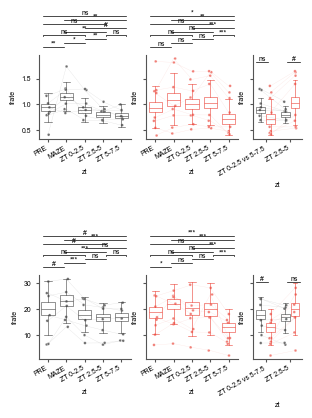

In [232]:
fig = subjects.SdFig().fig2(10)
dropRatJ = False  # RatJ Day1 has 12 pyr + 1 inter and meets our exclusion criteria

palette = subjects.colors_sd(1)
palette_light = subjects.colors_sd_light(1)

frate_df = grpdata.frate_blocks_bootstrap_session_neurons if not dropRatJ else grpdata.frate_blocks_bootstrap_session_neurons_dropRatJ
# frate_df = grpdata.frate_blocks_bootstrap_session_neurons_bak
frate_df_sess = grpdata.frate_post_chunks
if dropRatJ:
    frate_df_sess = frate_df_sess[frate_df_sess.name != "RatJDay1"]
frate_sess_mean = (
    frate_df_sess.groupby(["grp", "zt", "session", "neuron_type"], sort=False)
    .mean(numeric_only=True)
    .reset_index()
)

annotator_list = []
for i, ntype in enumerate(["pyr", "inter"]):
    ntype_df = frate_df[frate_df.neuron_type == ntype]
    ntype_mean_df = frate_sess_mean[frate_sess_mean.neuron_type == ntype]
    # ylims = (0.2, 2) if ntype == "pyr" else (5, 35)
    fig_row = 2 * i + 1
    subfig = fig.add_subfigure(fig.gs[fig_row, :4])
    axs = subfig.subplots(1, 3, sharey=True, width_ratios=[1.5, 1.5, 0.8])

    for g, grp in enumerate(["NSD", "SD"]):
        # ax = fig.subplot(gs_[i, g])
        ax = axs[g]
        p1 = Plotter(data=ntype_df[ntype_df.grp == grp], x="zt", y="frate", ax=ax)
        print(f"\n\033[4m{ntype} {grp} stats\033[0m:")
        annotator_list.append(p1.boxplot_sd2(palette=[palette[g]], zorder=3).stat_anot(
            stat_within=get_bootstrap_prob_paired,
            # alpha_within=0.025,
            alpha_within=[0.025, 0.005, 0.0005],
            alpha_trend=0.05,
            fontsize=5,
            verbose=True,
            prepend=(grp, ntype),
        ))

        p2 = Plotter(
            data=ntype_mean_df[ntype_mean_df.grp == grp], x="zt", y="frate", ax=ax
        )
        p2.striplineplot_sd(palette=[palette_light[g]])

        # ax.set_ylim(*ylims)

    ax = axs[2]
    df = get_nsd_vs_sd_df(ntype_df)
    df2 = get_nsd_vs_sd_df(ntype_mean_df)
    print(f"\n\033[4m{ntype} NSD vs stats\033[0m:")
    p1 = Plotter(data=df, x="zt", y="frate", hue="grp", ax=ax)
    annotator_list.append(p1.boxplot_sd2(palette=palette, zorder=3).stat_anot_sd(
        stat_across=get_bootstrap_prob,
        alpha_across=[0.05, 0.01, 0.001],
        alpha_trend_across=0.10,
        fontsize=5,
        verbose=True,
        prepend=("b/w", ntype),
    ))

    p2 = Plotter(data=df2, x="zt", y="frate", hue="grp", hue_order=["NSD", "SD"], ax=ax)
    p2.striplineplot_sd(palette=palette_light)

    # ax.set_ylim(*ylims)

drop_append = "_dropRatJ" if dropRatJ else ""
fig.savefig(subjects.figpath_sd / f"frate_blocks{drop_append}", format="svg")

In [233]:
pd.DataFrame(flatten(flatten(annotator_list)), columns=["grp", "neuron_type", "comp1", "comp2", "test", "pval", "test_stat"])

,grp,neuron_type,comp1,comp2,test,pval,test_stat
0,NSD,pyr,PRE,MAZE,"get_bootstrap_prob_paired,",1.400e-03,-2.083e-01
1,NSD,pyr,MAZE,ZT 0-2.5,"get_bootstrap_prob_paired,",1.390e-02,2.506e-01
2,NSD,pyr,ZT 0-2.5,ZT 2.5-5,"get_bootstrap_prob_paired,",1.400e-03,9.680e-02
3,NSD,pyr,ZT 2.5-5,ZT 5-7.5,"get_bootstrap_prob_paired,",4.047e-01,1.128e-02
4,NSD,pyr,PRE,ZT 0-2.5,"get_bootstrap_prob_paired,",3.518e-01,4.236e-02
5,NSD,pyr,MAZE,ZT 2.5-5,"get_bootstrap_prob_paired,",8.000e-04,3.474e-01
6,NSD,pyr,ZT 0-2.5,ZT 5-7.5,"get_bootstrap_prob_paired,",3.470e-02,1.081e-01
7,NSD,pyr,PRE,ZT 2.5-5,"get_bootstrap_prob_paired,",1.716e-01,1.392e-01
8,NSD,pyr,MAZE,ZT 5-7.5,"get_bootstrap_prob_paired,",1.500e-03,3.587e-01
9,NSD,pyr,PRE,ZT 5-7.5,"get_bootstrap_prob_paired,",1.420e-01,1.504e-01


In [4]:
# Generate table of neuron counts for each session below
neuron_counts = frate_df_sess[frate_df_sess.zt == "PRE"].drop(columns=["zt", "neuron_id"]).groupby(["grp", "session", "neuron_type"]).count().reset_index()
neuron_counts.drop(columns="session").groupby(["grp", "neuron_type"]).sum()

name  frate
grp neuron_type             
NSD inter          48     48
    pyr           441    441
SD  inter          48     48
    pyr           312    312

In [5]:
# broken down by session
# neuron_counts

In [7]:
q1 = (
    frate_df[frate_df.neuron_type == "inter"]
    .groupby(["grp", "zt"], sort=True)
    .quantile(0.25, numeric_only=True)
)
q3 = (
    frate_df[frate_df.neuron_type == "inter"]
    .groupby(["grp", "zt"], sort=True)
    .quantile(0.75, numeric_only=True)
)
q3 - q1

frate
grp zt                
NSD MAZE      4.300036
    PRE       5.225626
    ZT 0-2.5  3.372898
    ZT 2.5-5  2.918938
    ZT 5-7.5  3.021396
SD  MAZE      3.880091
    PRE       4.119275
    ZT 0-2.5  5.323766
    ZT 2.5-5  5.010631
    ZT 5-7.5  3.472396

In [48]:
# Get mean, median, IQR
boot_df = subjects.GroupData().frate_blocks_bootstrap_session_neurons
boot_df["zt"] = pd.Categorical(boot_df["zt"], ["PRE", "MAZE", "ZT 0-2.5", "ZT 2.5-5", "ZT 5-7.5"])
boot_df.groupby(["neuron_type", "grp", "zt"]).aggregate(
    ["mean", "median", lambda x: x.quantile(0.75) - x.quantile(0.25)]
)

frate                      
                               mean     median <lambda_0>
neuron_type grp zt                                       
inter       NSD PRE       20.341478  20.288565   5.225626
                MAZE      23.354324  23.377961   4.300036
                ZT 0-2.5  17.910465  17.977217   3.372898
                ZT 2.5-5  16.755372  16.915520   2.918938
                ZT 5-7.5  16.859832  16.981367   3.021396
            SD  PRE       18.716192  18.885896   4.119275
                MAZE      21.958457  22.243265   3.880091
                ZT 0-2.5  20.275343  20.565084   5.323766
                ZT 2.5-5  20.029600  20.236036   5.010631
                ZT 5-7.5  13.026340  13.212771   3.472396
pyr         NSD PRE        0.938370   0.943184   0.143684
                MAZE       1.146640   1.149772   0.142467
                ZT 0-2.5   0.896008   0.883960   0.116560
                ZT 2.5-5   0.799207   0.790748   0.089388
                ZT 5-7.5   0.787926   0.777999   0.109184
            SD  PRE        0.950643   0.933327   0.204172
                MAZE       1.107693   1.091642   0.259399
                ZT 0-2.5   1.011034   0.995782   0.197139
                ZT 2.5-5   1.039872   1.024234   0.224929
                ZT 5-7.5   0.723041   0.704964   0.194327

### EDF 5B: Firing rate in 1h chunks


pyr NSD stats:
p-value annotation legend:
      ns: 1.00e-01 < p <= 1.00e+00
       #: 2.50e-02 < p <= 1.00e-01
       *: 5.00e-03 < p <= 2.50e-02
      **: 5.00e-04 < p <= 5.00e-03
     ***: p <= 5.00e-04

PRE vs. MAZE: get_bootstrap_prob_paired, P_val:3.200e-03 Stat=-2.049e-01
MAZE vs. 0-1: get_bootstrap_prob_paired, P_val:2.013e-01 Stat=9.032e-02
0-1 vs. 4-5: get_bootstrap_prob_paired, P_val:1.600e-03 Stat=2.476e-01
4-5 vs. 5-6: get_bootstrap_prob_paired, P_val:4.635e-01 Stat=7.269e-03
PRE vs. 0-1: get_bootstrap_prob_paired, P_val:1.903e-01 Stat=-1.145e-01
MAZE vs. 4-5: get_bootstrap_prob_paired, P_val:5.000e-03 Stat=3.379e-01
0-1 vs. 5-6: get_bootstrap_prob_paired, P_val:2.200e-03 Stat=2.548e-01
PRE vs. 4-5: get_bootstrap_prob_paired, P_val:1.896e-01 Stat=1.330e-01
MAZE vs. 5-6: get_bootstrap_prob_paired, P_val:4.800e-03 Stat=3.452e-01
PRE vs. 5-6: get_bootstrap_prob_paired, P_val:1.745e-01 Stat=1.403e-01

pyr SD stats:
p-value annotation legend:
      ns: 1.00e-01 < p <= 1.00e+00

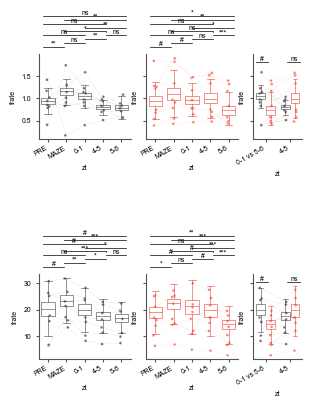

In [3]:
fig = subjects.SdFig().fig2(10)

palette = subjects.colors_sd(1)
palette_light = subjects.colors_sd_light(1)

frate_df = grpdata.frate_1h_blocks_bootstrap
frate_df_sess = grpdata.frate_1h_blocks
frate_sess_mean = (
    frate_df_sess.groupby(["grp", "zt", "session", "neuron_type"], sort=False)
    .mean(numeric_only=True)
    .reset_index()
)

for i, ntype in enumerate(["pyr", "inter"]):
    ntype_df = frate_df[frate_df.neuron_type == ntype]
    ntype_mean_df = frate_sess_mean[frate_sess_mean.neuron_type == ntype]
    # ylims = (0.2, 2) if ntype == "pyr" else (5, 35)
    fig_row = 2 * i + 1
    subfig = fig.add_subfigure(fig.gs[fig_row, :4])
    axs = subfig.subplots(1, 3, sharey=True, width_ratios=[1.5, 1.5, 0.8])

    for g, grp in enumerate(["NSD", "SD"]):
        # ax = fig.subplot(gs_[i, g])
        ax = axs[g]
        p1 = Plotter(data=ntype_df[ntype_df.grp == grp], x="zt", y="frate", ax=ax)
        print(f"\n\033[4m{ntype} {grp} stats\033[0m:")
        p1.boxplot_sd2(palette=[palette[g]], zorder=3).stat_anot(
            stat_within=get_bootstrap_prob_paired,
            # alpha_within=0.025,
            alpha_within=[0.025, 0.005, 0.0005],
            fontsize=5,
            verbose=True,
        )

        p2 = Plotter(
            data=ntype_mean_df[ntype_mean_df.grp == grp], x="zt", y="frate", ax=ax
        )
        p2.striplineplot_sd(palette=[palette_light[g]])

        # ax.set_ylim(*ylims)

    ax = axs[2]
    df = get_nsd_vs_sd_df(ntype_df, block_size=1)
    df2 = get_nsd_vs_sd_df(ntype_mean_df, block_size=1)
    print(f"\n\033[4m{ntype} NSD vs stats\033[0m:")
    p1 = Plotter(data=df, x="zt", y="frate", hue="grp", ax=ax)
    p1.boxplot_sd2(palette=palette, zorder=3).stat_anot_sd(
        stat_across=get_bootstrap_prob,
        alpha_across=[0.05, 0.01, 0.001],
        fontsize=5,
        verbose=True,
    )

    p2 = Plotter(data=df2, x="zt", y="frate", hue="grp", hue_order=["NSD", "SD"], ax=ax)
    p2.striplineplot_sd(palette=palette_light)

    # ax.set_ylim(*ylims)

fig.savefig(subjects.figpath_sd / "frate_1h_blocks", format="svg")

### Firing rates zscore normalized to PRE


pyr NSD stats:
p-value annotation legend:
      ns: 1.00e-01 < p <= 1.00e+00
       #: 2.50e-02 < p <= 1.00e-01
       *: 5.00e-03 < p <= 2.50e-02
      **: 5.00e-04 < p <= 5.00e-03
     ***: p <= 5.00e-04

PRE vs. MAZE: get_bootstrap_prob_paired, P_val:1.040e-02 Stat=-3.291e+00
MAZE vs. ZT 0-2.5: get_bootstrap_prob_paired, P_val:2.390e-02 Stat=2.112e+00
ZT 0-2.5 vs. ZT 2.5-5: get_bootstrap_prob_paired, P_val:1.909e-01 Stat=3.582e-01
ZT 2.5-5 vs. ZT 5-7.5: get_bootstrap_prob_paired, P_val:7.860e-02 Stat=7.708e-01
PRE vs. ZT 0-2.5: get_bootstrap_prob_paired, P_val:2.423e-01 Stat=-1.179e+00
MAZE vs. ZT 2.5-5: get_bootstrap_prob_paired, P_val:3.650e-02 Stat=2.470e+00
ZT 0-2.5 vs. ZT 5-7.5: get_bootstrap_prob_paired, P_val:5.540e-02 Stat=1.129e+00
PRE vs. ZT 2.5-5: get_bootstrap_prob_paired, P_val:2.681e-01 Stat=-8.205e-01
MAZE vs. ZT 5-7.5: get_bootstrap_prob_paired, P_val:3.320e-02 Stat=3.241e+00
PRE vs. ZT 5-7.5: get_bootstrap_prob_paired, P_val:4.577e-01 Stat=-4.972e-02

pyr SD stats:

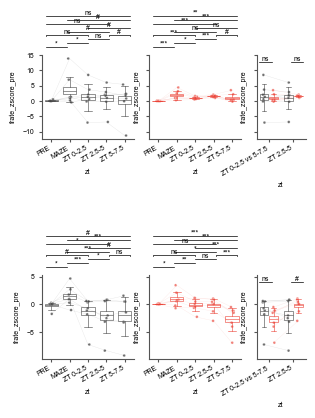

In [43]:
fig = subjects.SdFig().fig2(10)
dropRatJ = True

palette = subjects.colors_sd(1)
palette_light = subjects.colors_sd_light(1)

frate_df = grpdata.frate_blocks_bootstrap_session_neurons_zscore_pre if not dropRatJ else grpdata.frate_blocks_bootstrap_session_neurons_zscore_pre_dropRatJ
frate_df_sess = grpdata.frate_post_chunks_zscore_pre
if dropRatJ:
    frate_df_sess = frate_df_sess[frate_df_sess.name != "RatJDay1"]
frate_sess_mean = (
    frate_df_sess.groupby(["grp", "zt", "session", "neuron_type"], sort=False)
    .mean(numeric_only=True)
    .reset_index()
)

for i, ntype in enumerate(["pyr", "inter"]):
    ntype_df = frate_df[frate_df.neuron_type == ntype]
    ntype_mean_df = frate_sess_mean[frate_sess_mean.neuron_type == ntype]
    # ylims = (0.2, 2) if ntype == "pyr" else (5, 35)
    fig_row = 2 * i + 1
    subfig = fig.add_subfigure(fig.gs[fig_row, :4])
    axs = subfig.subplots(1, 3, sharey=True, width_ratios=[1.5, 1.5, 0.8])

    for g, grp in enumerate(["NSD", "SD"]):
        # ax = fig.subplot(gs_[i, g])
        ax = axs[g]
        p1 = Plotter(data=ntype_df[ntype_df.grp == grp], x="zt", y="frate_zscore_pre", ax=ax)
        print(f"\n\033[4m{ntype} {grp} stats\033[0m:")
        p1.boxplot_sd2(palette=[palette[g]], zorder=3).stat_anot(
            stat_within=get_bootstrap_prob_paired,
            alpha_within=[0.025, 0.005, 0.0005],
            fontsize=5,
            verbose=True,
        )

        p2 = Plotter(
            data=ntype_mean_df[ntype_mean_df.grp == grp], x="zt", y="frate_zscore_pre", ax=ax
        )
        p2.striplineplot_sd(palette=[palette_light[g]])

        # ax.set_ylim(*ylims)

    ax = axs[2]
    df = get_nsd_vs_sd_df(ntype_df)
    df2 = get_nsd_vs_sd_df(ntype_mean_df)
    print(f"\n\033[4m{ntype} NSD vs stats\033[0m:")
    p1 = Plotter(data=df, x="zt", y="frate_zscore_pre", hue="grp", ax=ax)
    p1.boxplot_sd2(palette=palette, zorder=3).stat_anot_sd(
        stat_across=get_bootstrap_prob,
        alpha_across=[0.05, 0.01, 0.001],
        fontsize=5,
        verbose=True,
    )

    p2 = Plotter(data=df2, x="zt", y="frate_zscore_pre", hue="grp", hue_order=["NSD", "SD"], ax=ax)
    p2.striplineplot_sd(palette=palette_light)

    # ax.set_ylim(*ylims)

drop_append = "_dropRatJ" if dropRatJ else ""
fig.savefig(subjects.figpath_sd / f"frate_blocks_zscore_pre{drop_append}", format="svg")

### Firing rate normalized to PRE and MAZE combined
Looks very weird - maybe I screwed something up?

In [ ]:
fig = subjects.SdFig().fig2(10)

palette = subjects.colors_sd(1)
palette_light = subjects.colors_sd_light(1)

frate_df = grpdata.frate_blocks_bootstrap_session_neurons_zscore_pre_maze
frate_df_sess = grpdata.frate_post_chunks_zscore_pre_maze
frate_sess_mean = (
    frate_df_sess.groupby(["grp", "zt", "session", "neuron_type"], sort=False)
    .mean(numeric_only=True)
    .reset_index()
)

for i, ntype in enumerate(["pyr", "inter"]):
    ntype_df = frate_df[frate_df.neuron_type == ntype]
    ntype_mean_df = frate_sess_mean[frate_sess_mean.neuron_type == ntype]
    # ylims = (0.2, 2) if ntype == "pyr" else (5, 35)
    fig_row = 2 * i + 1
    subfig = fig.add_subfigure(fig.gs[fig_row, :4])
    axs = subfig.subplots(1, 3, sharey=True, width_ratios=[1.5, 1.5, 0.8])

    for g, grp in enumerate(["NSD", "SD"]):
        # ax = fig.subplot(gs_[i, g])
        ax = axs[g]
        p1 = Plotter(data=ntype_df[ntype_df.grp == grp], x="zt", y="frate_zscore_pre_maze", ax=ax)
        print(f"\n\033[4m{ntype} {grp} stats\033[0m:")
        p1.boxplot_sd2(palette=[palette[g]], zorder=3).stat_anot(
            stat_within=get_bootstrap_prob_paired,
            alpha_within=[0.025, 0.005, 0.0005],
            fontsize=5,
            verbose=True,
        )

        p2 = Plotter(
            data=ntype_mean_df[ntype_mean_df.grp == grp], x="zt", y="frate_zscore_pre_maze", ax=ax
        )
        p2.striplineplot_sd(palette=[palette_light[g]])

        # ax.set_ylim(*ylims)

    ax = axs[2]
    df = get_nsd_vs_sd_df(ntype_df)
    df2 = get_nsd_vs_sd_df(ntype_mean_df)
    print(f"\n\033[4m{ntype} NSD vs stats\033[0m:")
    p1 = Plotter(data=df, x="zt", y="frate_zscore_pre_maze", hue="grp", ax=ax)
    p1.boxplot_sd2(palette=palette, zorder=3).stat_anot_sd(
        stat_across=get_bootstrap_prob,
        alpha_across=[0.05, 0.01, 0.001],
        fontsize=5,
        verbose=True,
    )

    p2 = Plotter(data=df2, x="zt", y="frate_zscore_pre_maze", hue="grp", hue_order=["NSD", "SD"], ax=ax)
    p2.striplineplot_sd(palette=palette_light)

    # ax.set_ylim(*ylims)

fig.savefig(subjects.figpath_sd / "frate_blocks_zscore_pre_maze", format="svg")

### Firing rates normalized to MAZE

In [ ]:
fig = subjects.SdFig().fig2(10)

palette = subjects.colors_sd(1)
palette_light = subjects.colors_sd_light(1)

frate_df = grpdata.frate_blocks_bootstrap_session_neurons_zscore_maze
frate_df_sess = grpdata.frate_post_chunks_zscore_maze
frate_sess_mean = (
    frate_df_sess.groupby(["grp", "zt", "session", "neuron_type"], sort=False)
    .mean(numeric_only=True)
    .reset_index()
)

for i, ntype in enumerate(["pyr", "inter"]):
    ntype_df = frate_df[frate_df.neuron_type == ntype]
    ntype_mean_df = frate_sess_mean[frate_sess_mean.neuron_type == ntype]
    # ylims = (0.2, 2) if ntype == "pyr" else (5, 35)
    fig_row = 2 * i + 1
    subfig = fig.add_subfigure(fig.gs[fig_row, :4])
    axs = subfig.subplots(1, 3, sharey=True, width_ratios=[1.5, 1.5, 0.8])

    for g, grp in enumerate(["NSD", "SD"]):
        # ax = fig.subplot(gs_[i, g])
        ax = axs[g]
        p1 = Plotter(data=ntype_df[ntype_df.grp == grp], x="zt", y="frate_zscore_maze", ax=ax)
        print(f"\n\033[4m{ntype} {grp} stats\033[0m:")
        p1.boxplot_sd2(palette=[palette[g]], zorder=3).stat_anot(
            stat_within=get_bootstrap_prob_paired,
            alpha_within=[0.025, 0.005, 0.0005],
            fontsize=5,
            verbose=True,
        )

        p2 = Plotter(
            data=ntype_mean_df[ntype_mean_df.grp == grp], x="zt", y="frate_zscore_maze", ax=ax
        )
        p2.striplineplot_sd(palette=[palette_light[g]])

        # ax.set_ylim(*ylims)

    ax = axs[2]
    df = get_nsd_vs_sd_df(ntype_df)
    df2 = get_nsd_vs_sd_df(ntype_mean_df)
    print(f"\n\033[4m{ntype} NSD vs stats\033[0m:")
    p1 = Plotter(data=df, x="zt", y="frate_zscore_maze", hue="grp", ax=ax)
    p1.boxplot_sd2(palette=palette, zorder=3).stat_anot_sd(
        stat_across=get_bootstrap_prob,
        alpha_across=[0.05, 0.01, 0.001],
        fontsize=5,
        verbose=True,
    )

    p2 = Plotter(data=df2, x="zt", y="frate_zscore_maze", hue="grp", hue_order=["NSD", "SD"], ax=ax)
    p2.striplineplot_sd(palette=palette_light)

    # ax.set_ylim(*ylims)

fig.savefig(subjects.figpath_sd / "frate_blocks_zscore_maze", format="svg")

### Firing rates divided by pre/baseline (Vyazovskiy method)


pyr NSD stats:
p-value annotation legend:
      ns: 1.00e-01 < p <= 1.00e+00
       #: 2.50e-02 < p <= 1.00e-01
       *: 5.00e-03 < p <= 2.50e-02
      **: 5.00e-04 < p <= 5.00e-03
     ***: p <= 5.00e-04

PRE vs. MAZE: get_bootstrap_prob_paired, P_val:1.200e-03 Stat=-4.902e+02
MAZE vs. ZT 0-2.5: get_bootstrap_prob_paired, P_val:1.315e-01 Stat=2.434e+02
ZT 0-2.5 vs. ZT 2.5-5: get_bootstrap_prob_paired, P_val:1.811e-01 Stat=8.690e+01
ZT 2.5-5 vs. ZT 5-7.5: get_bootstrap_prob_paired, P_val:1.642e-01 Stat=3.168e+01
PRE vs. ZT 0-2.5: get_bootstrap_prob_paired, P_val:0.000e+00 Stat=-2.467e+02
MAZE vs. ZT 2.5-5: get_bootstrap_prob_paired, P_val:1.445e-01 Stat=3.303e+02
ZT 0-2.5 vs. ZT 5-7.5: get_bootstrap_prob_paired, P_val:1.804e-01 Stat=1.186e+02
PRE vs. ZT 2.5-5: get_bootstrap_prob_paired, P_val:0.000e+00 Stat=-1.598e+02
MAZE vs. ZT 5-7.5: get_bootstrap_prob_paired, P_val:1.530e-01 Stat=3.620e+02
PRE vs. ZT 5-7.5: get_bootstrap_prob_paired, P_val:0.000e+00 Stat=-1.282e+02

pyr SD stats:

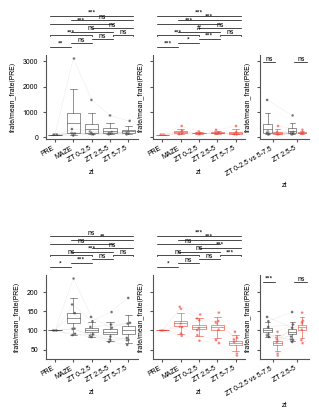

In [44]:
fig = subjects.SdFig().fig2(10)
dropRatJ = True

palette = subjects.colors_sd(1)
palette_light = subjects.colors_sd_light(1)

frate_df = grpdata.frate_blocks_bootstrap_session_neurons_change_pre_to_post if not dropRatJ else grpdata.frate_blocks_bootstrap_session_neurons_change_pre_to_post_dropRatJ
frate_df_sess = grpdata.frate_change_pre_to_post
if dropRatJ:
    frate_df_sess = frate_df_sess[frate_df_sess.name != "RatJDay1"]
frate_sess_mean = (
    frate_df_sess.groupby(["grp", "zt", "session", "neuron_type"], sort=False)
    .mean(numeric_only=True)
    .reset_index()
)

for i, ntype in enumerate(["pyr", "inter"]):
    ntype_df = frate_df[frate_df.neuron_type == ntype]
    ntype_mean_df = frate_sess_mean[frate_sess_mean.neuron_type == ntype]
    # ylims = (0.2, 2) if ntype == "pyr" else (5, 35)
    fig_row = 2 * i + 1
    subfig = fig.add_subfigure(fig.gs[fig_row, :4])
    axs = subfig.subplots(1, 3, sharey=True, width_ratios=[1.5, 1.5, 0.8])

    for g, grp in enumerate(["NSD", "SD"]):
        # ax = fig.subplot(gs_[i, g])
        ax = axs[g]
        p1 = Plotter(data=ntype_df[ntype_df.grp == grp], x="zt", y="frate/mean_frate(PRE)", ax=ax)
        print(f"\n\033[4m{ntype} {grp} stats\033[0m:")
        p1.boxplot_sd2(palette=[palette[g]], zorder=3).stat_anot(
            stat_within=get_bootstrap_prob_paired,
            alpha_within=[0.025, 0.005, 0.0005],
            fontsize=5,
            verbose=True,
        )

        p2 = Plotter(
            data=ntype_mean_df[ntype_mean_df.grp == grp], x="zt", y="frate/mean_frate(PRE)", ax=ax
        )
        p2.striplineplot_sd(palette=[palette_light[g]])

        # ax.set_ylim(*ylims)

    ax = axs[2]
    df = get_nsd_vs_sd_df(ntype_df)
    df2 = get_nsd_vs_sd_df(ntype_mean_df)
    print(f"\n\033[4m{ntype} NSD vs SD stats\033[0m:")
    p1 = Plotter(data=df, x="zt", y="frate/mean_frate(PRE)", hue="grp", ax=ax)
    p1.boxplot_sd2(palette=palette, zorder=3).stat_anot_sd(
        stat_across=get_bootstrap_prob,
        alpha_across=[0.05, 0.01, 0.001],
        fontsize=5,
        verbose=True,
    )

    p2 = Plotter(data=df2, x="zt", y="frate/mean_frate(PRE)", hue="grp", hue_order=["NSD", "SD"], ax=ax)
    p2.striplineplot_sd(palette=palette_light)

    # ax.set_ylim(*ylims)

drop_append = "_dropRatJ" if dropRatJ else ""
fig.savefig(subjects.figpath_sd / f"frate_blocks_change_pre_to_post{drop_append}", format="svg")

In [ ]:
# Find session with wonky high firing rate - session 3 - NSD
frate_sess_mean[frate_sess_mean.zt == 'MAZE'][frate_sess_mean[frate_sess_mean.zt == 'MAZE']['frate/mean_frate(PRE)'].values > 3000]

In [ ]:
# Count #s of cells of each type - weird to have such a crazy increase with 60 cells!!! must have had a noisy pre recording.
frate_df_sess[(frate_df_sess.session == 3)].groupby("neuron_type").count()

### Log firing rates

In [ ]:
fig = subjects.SdFig().fig2(10)

palette = subjects.colors_sd(1)
palette_light = subjects.colors_sd_light(1)

frate_df = grpdata.frate_blocks_bootstrap_session_neurons_log
frate_df_sess = grpdata.frate_log_post_chunks
frate_sess_mean = (
    frate_df_sess.groupby(["grp", "zt", "session", "neuron_type"], sort=False)
    .mean(numeric_only=True)
    .reset_index()
)

for i, ntype in enumerate(["pyr", "inter"]):
    ntype_df = frate_df[frate_df.neuron_type == ntype]
    ntype_mean_df = frate_sess_mean[frate_sess_mean.neuron_type == ntype]
    # ylims = (0.2, 2) if ntype == "pyr" else (5, 35)
    fig_row = 2 * i + 1
    subfig = fig.add_subfigure(fig.gs[fig_row, :4])
    axs = subfig.subplots(1, 3, sharey=True, width_ratios=[1.5, 1.5, 0.8])

    for g, grp in enumerate(["NSD", "SD"]):
        # ax = fig.subplot(gs_[i, g])
        ax = axs[g]
        p1 = Plotter(data=ntype_df[ntype_df.grp == grp], x="zt", y="log(frate)", ax=ax)
        print(f"\n\033[4m{ntype} {grp} stats\033[0m:")
        p1.boxplot_sd2(palette=[palette[g]], zorder=3).stat_anot(
            stat_within=get_bootstrap_prob_paired,
            alpha_within=[0.025, 0.005, 0.0005],
            fontsize=5,
            verbose=True,
        )

        p2 = Plotter(
            data=ntype_mean_df[ntype_mean_df.grp == grp], x="zt", y="log(frate)", ax=ax
        )
        p2.striplineplot_sd(palette=[palette_light[g]])

        # ax.set_ylim(*ylims)

    ax = axs[2]
    df = get_nsd_vs_sd_df(ntype_df)
    df2 = get_nsd_vs_sd_df(ntype_mean_df)
    print(f"\n\033[4m{ntype} NSD vs stats\033[0m:")
    p1 = Plotter(data=df, x="zt", y="log(frate)", hue="grp", ax=ax)
    p1.boxplot_sd2(palette=palette, zorder=3).stat_anot_sd(
        stat_across=get_bootstrap_prob,
        alpha_across=[0.05, 0.01, 0.001],
        fontsize=5,
        verbose=True,
    )

    p2 = Plotter(data=df2, x="zt", y="log(frate)", hue="grp", hue_order=["NSD", "SD"], ax=ax)
    p2.striplineplot_sd(palette=palette_light)

    # ax.set_ylim(*ylims)

fig.savefig(subjects.figpath_sd / "frate_blocks_log", format="svg")

### 2E: IQR for pyr cells
See `sd_figue2_supp.ipynb` "Normality tests for firing rate - IQR plots" tab 

### 2F-G: Firing rates inside ripples

In [35]:
boot_df = subjects.GroupData().frate_in_ripple_blocks_bootstrap_session_neurons
boot_df.groupby(["neuron_type", "grp", "zt"]).aggregate(
    ["mean", "median", lambda x: x.quantile(0.75) - x.quantile(0.25)]
)

frate                      
                               mean     median <lambda_0>
neuron_type grp zt                                       
inter       NSD MAZE      42.752044  42.551263   7.126911
                PRE       44.680948  44.706413   7.249680
                ZT 0-2.5  49.370022  49.461626   7.854974
                ZT 2.5-5  45.164490  45.386012   7.535102
                ZT 5-7.5  44.633747  44.785280   6.724570
            SD  MAZE      39.583384  39.798025   6.848576
                PRE       38.230703  38.244794   7.297050
                ZT 0-2.5  40.661332  40.692451   8.280909
                ZT 2.5-5  37.373522  37.552446   6.610010
                ZT 5-7.5  34.108787  34.487830   7.108280
pyr         NSD MAZE       3.416727   3.314212   0.843366
                PRE        3.202949   3.171833   0.848805
                ZT 0-2.5   3.714970   3.635972   1.176280
                ZT 2.5-5   3.437302   3.361032   1.027664
                ZT 5-7.5   3.181566   3.120013   0.933993
            SD  MAZE       3.381628   3.303680   1.017115
                PRE        3.177357   3.076975   1.201612
                ZT 0-2.5   3.652350   3.543392   1.363351
                ZT 2.5-5   3.706899   3.598315   1.241538
                ZT 5-7.5   3.483673   3.383056   1.216976


pyr NSD stats:
p-value annotation legend:
      ns: 1.00e-01 < p <= 1.00e+00
       #: 2.50e-02 < p <= 1.00e-01
       *: 5.00e-03 < p <= 2.50e-02
      **: 5.00e-04 < p <= 5.00e-03
     ***: p <= 5.00e-04

PRE vs. MAZE: get_bootstrap_prob_paired, P_val:3.245e-01 Stat=-2.138e-01
MAZE vs. ZT 0-2.5: get_bootstrap_prob_paired, P_val:3.142e-01 Stat=-2.982e-01
ZT 0-2.5 vs. ZT 2.5-5: get_bootstrap_prob_paired, P_val:9.100e-03 Stat=2.777e-01
ZT 2.5-5 vs. ZT 5-7.5: get_bootstrap_prob_paired, P_val:2.500e-02 Stat=2.557e-01
PRE vs. ZT 0-2.5: get_bootstrap_prob_paired, P_val:2.400e-03 Stat=-5.120e-01
MAZE vs. ZT 2.5-5: get_bootstrap_prob_paired, P_val:4.856e-01 Stat=-2.058e-02
ZT 0-2.5 vs. ZT 5-7.5: get_bootstrap_prob_paired, P_val:1.800e-03 Stat=5.334e-01
PRE vs. ZT 2.5-5: get_bootstrap_prob_paired, P_val:1.549e-01 Stat=-2.344e-01
MAZE vs. ZT 5-7.5: get_bootstrap_prob_paired, P_val:3.017e-01 Stat=2.352e-01
PRE vs. ZT 5-7.5: get_bootstrap_prob_paired, P_val:4.045e-01 Stat=2.138e-02

pyr SD stats

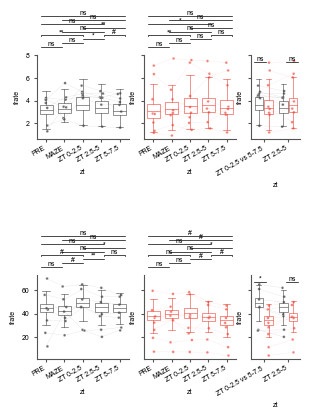

In [234]:
fig = subjects.SdFig().fig2(10)

palette = subjects.colors_sd(1)
palette_light = subjects.colors_sd_light(1)

frate_df = grpdata.frate_in_ripple_blocks_bootstrap_session_neurons
frate_df_sess = grpdata.frate_in_ripple
frate_df_sess = frate_df_sess[frate_df_sess["where"] == "inside"]
frate_sess_mean = (
    frate_df_sess.groupby(["grp", "zt", "session", "neuron_type"], sort=False)
    .mean(numeric_only=True)
    .reset_index()
)

order = ["PRE", "MAZE", "0-2.5", "2.5-5", "5-7.5"]

results_list = []
for i, ntype in enumerate(["pyr", "inter"]):
    ntype_df = frate_df[frate_df.neuron_type == ntype]
    ntype_mean_df = frate_sess_mean[frate_sess_mean.neuron_type == ntype]
    # ylims = (0.2, 2) if ntype == "pyr" else (5, 35)
    fig_row = 2 * i + 1
    subfig = fig.add_subfigure(fig.gs[fig_row, :4])
    axs = subfig.subplots(1, 3, sharey=True, width_ratios=[1.5, 1.5, 0.8])

    for g, grp in enumerate(["NSD", "SD"]):
        # ax = fig.subplot(gs_[i, g])
        ax = axs[g]
        print(f"\n\033[4m{ntype} {grp} stats\033[0m:")
        p1 = Plotter(data=ntype_df[ntype_df.grp == grp], x="zt", y="frate", ax=ax)
        results_list.append(p1.boxplot_sd2(palette=[palette[g]], zorder=3).stat_anot(
            stat_within=get_bootstrap_prob_paired,
            alpha_within=[0.025, 0.005, 0.0005],
            fontsize=5,
            verbose=True,
            prepend=(grp, ntype),
        ))

        p2 = Plotter(
            data=ntype_mean_df[ntype_mean_df.grp == grp], x="zt", y="frate", ax=ax
        )
        p2.striplineplot_sd(palette=[palette_light[g]])

        # ax.set_ylim(*ylims)

    ax = axs[2]
    df = get_nsd_vs_sd_df(ntype_df)
    df2 = get_nsd_vs_sd_df(ntype_mean_df)
    p1 = Plotter(data=df, x="zt", y="frate", hue="grp", ax=ax)
    print(f"\n\033[4m{ntype} NSD vs SD stats\033[0m:")
    results_list.append(p1.boxplot_sd2(palette=palette, zorder=3).stat_anot_sd(
        stat_across=get_bootstrap_prob,
        alpha_across=[0.05, 0.01, 0.001],
        fontsize=5,
        verbose=True,
        prepend=("b/w", ntype),
    ))
    p2 = Plotter(data=df2, x="zt", y="frate", hue="grp", hue_order=["NSD", "SD"], ax=ax)
    p2.striplineplot_sd(palette=palette_light)
    # ax.set_ylim(*ylims)

fig.savefig(subjects.figpath_sd / "frate_in_ripple", format="svg")

In [235]:
pd.DataFrame(flatten(flatten(results_list)), columns=["grp", "neuron_type", "comp1", "comp2", "test", "pval", "test_stat"])

,grp,neuron_type,comp1,comp2,test,pval,test_stat
0,NSD,pyr,PRE,MAZE,"get_bootstrap_prob_paired,",3.245e-01,-2.138e-01
1,NSD,pyr,MAZE,ZT 0-2.5,"get_bootstrap_prob_paired,",3.142e-01,-2.982e-01
2,NSD,pyr,ZT 0-2.5,ZT 2.5-5,"get_bootstrap_prob_paired,",9.100e-03,2.777e-01
3,NSD,pyr,ZT 2.5-5,ZT 5-7.5,"get_bootstrap_prob_paired,",2.500e-02,2.557e-01
4,NSD,pyr,PRE,ZT 0-2.5,"get_bootstrap_prob_paired,",2.400e-03,-5.120e-01
5,NSD,pyr,MAZE,ZT 2.5-5,"get_bootstrap_prob_paired,",4.856e-01,-2.058e-02
6,NSD,pyr,ZT 0-2.5,ZT 5-7.5,"get_bootstrap_prob_paired,",1.800e-03,5.334e-01
7,NSD,pyr,PRE,ZT 2.5-5,"get_bootstrap_prob_paired,",1.549e-01,-2.344e-01
8,NSD,pyr,MAZE,ZT 5-7.5,"get_bootstrap_prob_paired,",3.017e-01,2.352e-01
9,NSD,pyr,PRE,ZT 5-7.5,"get_bootstrap_prob_paired,",4.045e-01,2.138e-02


### Firing rate IQR comparison

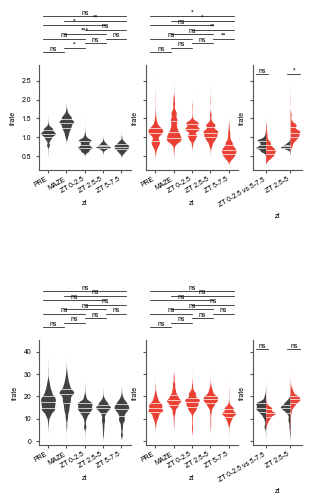

In [19]:
fig = subjects.SdFig().fig2()

palette = subjects.colors_sd(1)

frate_df = grpdata.frate_IQR_blocks_bootstrap_session_neurons

for i, ntype in enumerate(["pyr", "inter"]):
    ntype_df = frate_df[frate_df.neuron_type == ntype]
    # ylims = (0.2, 2) if ntype == "pyr" else (5, 35)
    fig_row = 2 * i + 1
    subfig = fig.add_subfigure(fig.gs[fig_row, :4])
    axs = subfig.subplots(1, 3, sharey=True, width_ratios=[1.5, 1.5, 0.8])

    for g, grp in enumerate(["NSD", "SD"]):
        # ax = fig.subplot(gs_[i, g])
        ax = axs[g]
        plotter = Plotter(data=ntype_df[ntype_df.grp == grp], x="zt", y="frate", ax=ax)
        plotter.violinplot_sd(palette=[palette[g]]).stat_anot(
            stat_within=get_bootstrap_prob_paired, alpha_within=[0.025, 0.005, 0.0005], fontsize=5
        )
        # ax.set_ylim(*ylims)

    ax = axs[2]
    df = get_nsd_vs_sd_df(ntype_df)
    plotter = Plotter(data=df, x="zt", y="frate", hue="grp", ax=ax)
    plotter.violinplot_sd(split=True, palette=palette).stat_anot_sd(
        stat_across=get_bootstrap_prob,
        alpha_across=[0.05, 0.01, 0.001],
        fontsize=5,
    )
    # ax.set_ylim(*ylims)

fig.savefig(subjects.figpath_sd / "fig2_frate_IQR.pdf")

### Put IQR (not log!) into same format as other figures


pyr NSD stats:
p-value annotation legend:
      ns: 1.00e-01 < p <= 1.00e+00
       #: 2.50e-02 < p <= 1.00e-01
       *: 5.00e-03 < p <= 2.50e-02
      **: 5.00e-04 < p <= 5.00e-03
     ***: p <= 5.00e-04

PRE vs. MAZE: get_bootstrap_prob_paired, P_val:3.200e-02 Stat=-2.810e-01
MAZE vs. ZT 0-2.5: get_bootstrap_prob_paired, P_val:1.090e-02 Stat=5.588e-01
ZT 0-2.5 vs. ZT 2.5-5: get_bootstrap_prob_paired, P_val:3.514e-01 Stat=4.533e-02
ZT 2.5-5 vs. ZT 5-7.5: get_bootstrap_prob_paired, P_val:4.264e-01 Stat=1.722e-02
PRE vs. ZT 0-2.5: get_bootstrap_prob_paired, P_val:6.130e-02 Stat=2.778e-01
MAZE vs. ZT 2.5-5: get_bootstrap_prob_paired, P_val:3.000e-04 Stat=6.041e-01
ZT 0-2.5 vs. ZT 5-7.5: get_bootstrap_prob_paired, P_val:2.677e-01 Stat=6.255e-02
PRE vs. ZT 2.5-5: get_bootstrap_prob_paired, P_val:2.470e-02 Stat=3.231e-01
MAZE vs. ZT 5-7.5: get_bootstrap_prob_paired, P_val:2.300e-03 Stat=6.214e-01
PRE vs. ZT 5-7.5: get_bootstrap_prob_paired, P_val:3.730e-02 Stat=3.403e-01

pyr SD stats:
p-

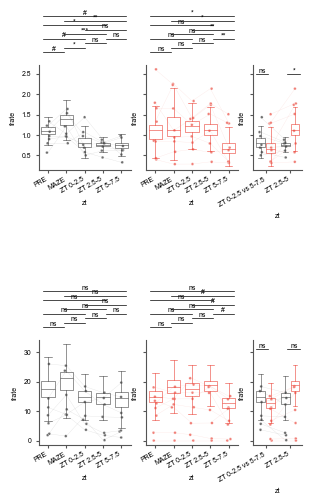

In [16]:
fig = subjects.SdFig().fig2()

palette = subjects.colors_sd(1)

boot_df = grpdata.frate_IQR_blocks_bootstrap_session_neurons
frate_df = subjects.GroupData().frate_post_chunks
frate_df = (
    frate_df.pivot_table(
        columns=["zt"],
        values=["frate"],
        index=["grp", "session", "neuron_id", "neuron_type"],
        sort=False,
    )
    .reset_index(col_level=1)
    .droplevel(0, axis=1)
    .drop(["neuron_id"], axis=1)
)
value_vars = ["PRE", "MAZE", "0-2.5", "2.5-5", "5-7.5"] if "0-2.5" in frate_df.keys() else ["PRE", "MAZE", "ZT 0-2.5", "ZT 2.5-5", "ZT 5-7.5"]
frate_df_mean = (frate_df.groupby(["grp", "session", "neuron_type"]).quantile([0.25, 0.75]).diff()
                 .iloc[1::2].reset_index()).melt(
        id_vars=["grp", "session", "neuron_type"],
        value_vars=value_vars,
        var_name="zt",
        value_name="frate",
)

for i, ntype in enumerate(["pyr", "inter"]):
    ntype_df = boot_df[boot_df.neuron_type == ntype]
    ntype_mean_df = frate_df_mean[frate_df_mean.neuron_type == ntype]
    # ylims = (0.2, 2) if ntype == "pyr" else (5, 35)
    fig_row = 2 * i + 1
    subfig = fig.add_subfigure(fig.gs[fig_row, :4])
    axs = subfig.subplots(1, 3, sharey=True, width_ratios=[1.5, 1.5, 0.8])

    for g, grp in enumerate(["NSD", "SD"]):
        # ax = fig.subplot(gs_[i, g])
        ax = axs[g]
        p1 = Plotter(data=ntype_df[ntype_df.grp == grp], x="zt", y="frate", ax=ax)
        print(f"\n\033[4m{ntype} {grp} stats\033[0m:")
        p1.boxplot_sd2(palette=[palette[g]], zorder=3).stat_anot(
            stat_within=get_bootstrap_prob_paired, 
            alpha_within=[0.025, 0.005, 0.0005], 
            fontsize=5,
            verbose=True,
        )

        p2 = Plotter(
            data=ntype_mean_df[ntype_mean_df.grp == grp], x="zt", y="frate", ax=ax
        )
        p2.striplineplot_sd(palette=[palette_light[g]])
        # ax.set_ylim(*ylims)

    ax = axs[2]
    df = get_nsd_vs_sd_df(ntype_df)
    df2 = get_nsd_vs_sd_df(ntype_mean_df)
    p1 = Plotter(data=df, x="zt", y="frate", hue="grp", ax=ax)
    print(f"\n\033[4m{ntype} NSD vs SD stats\033[0m:")
    p1.boxplot_sd2(palette=palette, zorder=3).stat_anot_sd(
        stat_across=get_bootstrap_prob,
        alpha_across=[0.05, 0.01, 0.001],
        fontsize=5,
        verbose=True,
    )
    p2 = Plotter(data=df2, x="zt", y="frate", hue="grp", ax=ax)
    p2.striplineplot_sd(palette=palette_light)

fig.savefig(subjects.figpath_sd / "fig2_frate_IQR_update")

### Calculate Shapiro-Wilks test on log(FR) (text only)
For reporting values on all neurons combined in text only.

In [27]:
frate_df[frate_df.neuron_type == "pyr"].drop(columns=["neuron_id", "session", "name", "neuron_type"]).groupby(["grp", "zt"]).apply(lambda x : np.log(x).quantile(0.75) - np.log(x).quantile(0.25))

frate
grp zt                
NSD MAZE      2.308465
    PRE       2.046030
    ZT 0-2.5  1.386032
    ZT 2.5-5  1.432940
    ZT 5-7.5  1.496460
SD  MAZE      1.944152
    PRE       2.079202
    ZT 0-2.5  2.115069
    ZT 2.5-5  1.896355
    ZT 5-7.5  1.430606

In [19]:
frate_df = subjects.GroupData().frate_post_chunks

sw_stats = []
for n_type, zt, grp in zip(["inter", "inter", "pyr", "pyr"], ["5-7.5", "0-2.5", "2.5-5", "2.5-5"], ["SD", "NSD", "SD", "NSD"]):
    df_use = frate_df[(frate_df.neuron_type == n_type) & (frate_df.zt == zt) & (frate_df.grp == grp)]
    sw_stat, sw_pvalue = stats.shapiro(np.log(df_use["frate"].values))
    print(f"{n_type} {grp} {zt} Shapiro-Wilks p-value = {sw_pvalue} (stat = {sw_stat}, n = {df_use.shape[0]})")

ValueError: Data must be at least length 3.

In [ ]:
# Compare to bootstrap
boot_stat_df = grpdata.frate_normality_statistic_blocks_bootstrap
boot_stat_mean = boot_stat_df.groupby(["grp", "neuron_type", "zt"]).mean().reset_index()
for n_type, zt, grp in zip(["inter", "inter", "pyr", "pyr"], ["5-7.5", "0-2.5", "2.5-5", "2.5-5"], ["SD", "NSD", "SD", "NSD"]):
    df_use = boot_stat_mean[(boot_stat_mean.neuron_type == n_type) & (boot_stat_mean.zt == zt) & (boot_stat_mean.grp == grp)]
    print(f"{n_type} {grp} {zt} mean bootstrap Shapiro-Wilks p-value = {df_use.shapiro_pvalue.values[0]} (stat = {df_use.shapiro.values[0]})")

# Add in n and export to csv
boot_stat_n = boot_stat_df.groupby(["grp", "neuron_type", "zt"]).count().reset_index().shapiro.values
boot_stat_mean.insert(8, "nboot", boot_stat_n)
boot_stat_mean.to_csv(subjects.GroupData().path / "normality_mean_values_boot.csv")

In [ ]:
frate_df = subjects.GroupData().frate_post_chunks
logshapiro = lambda frate: stats.shapiro(np.log(frate))[1] 
shapiro_df = frate_df.drop(columns=["session", "neuron_id"]).groupby(["grp", "neuron_type", "zt"]).apply(logshapiro).reset_index()
shapiro_df = shapiro_df.rename(columns={0: "shapiro_pvalue"})
ncells = frate_df.drop(columns=["session", "neuron_id"]).groupby(["grp", "neuron_type", "zt"]).count().reset_index().frate.values
shapiro_df.insert(4, "ncells", ncells)
shapiro_df.to_csv(subjects.GroupData().path / "shapiro_pvalues_raw.csv")
shapiro_df

### 2D: Violin plots of FR distributions with Shapiro-Wilk stats at top

In [6]:
boot_stat_df.drop(columns=["shapiro", "shapiro_pvalue", "skew", "skew_pvalue"]).groupby(["grp", "neuron_type", "zt"]).mean(numeric_only=True).reset_index()

,grp,neuron_type,zt,iqr
0,NSD,inter,MAZE,0.460434
1,NSD,inter,PRE,0.439793
2,NSD,inter,ZT 0-2.5,0.402601
3,NSD,inter,ZT 2.5-5,0.384526
4,NSD,inter,ZT 5-7.5,0.373388
5,NSD,pyr,MAZE,0.990720
6,NSD,pyr,PRE,0.880959
7,NSD,pyr,ZT 0-2.5,0.605834
8,NSD,pyr,ZT 2.5-5,0.626123
9,NSD,pyr,ZT 5-7.5,0.647424


pyr status below:
p-value annotation legend:
      ns: 1.00e-01 < p <= 1.00e+00
       #: 5.00e-02 < p <= 1.00e-01
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: p <= 1.00e-03

MAZE_NSD vs. MAZE_SD: get_bootstrap_prob, P_val:2.089e-01 Stat=1.079e+00
PRE_NSD vs. PRE_SD: get_bootstrap_prob, P_val:4.731e-01 Stat=7.750e-02
ZT 0-2.5_NSD vs. ZT 0-2.5_SD: get_bootstrap_prob, P_val:2.775e-02 Stat=2.672e+00
ZT 2.5-5_NSD vs. ZT 2.5-5_SD: get_bootstrap_prob, P_val:7.679e-02 Stat=1.891e+00
ZT 5-7.5_NSD vs. ZT 5-7.5_SD: get_bootstrap_prob, P_val:2.525e-01 Stat=9.397e-01
ZT 0-2.5_NSD vs. ZT 5-7.5_SD: get_bootstrap_prob, P_val:2.466e-01 Stat=9.133e-01
p-value annotation legend:
      ns: 1.00e-01 < p <= 1.00e+00
       #: 5.00e-02 < p <= 1.00e-01
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: p <= 1.00e-03

MAZE_NSD vs. MAZE_SD: get_bootstrap_prob, P_val:2.131e-01 Stat=1.105e+00
PRE_NSD vs. PRE_SD: get_bootstrap_prob, P_val:3.493e-01 S

,neuron_type,zt,grp,shapiro_pvalue,skew_pvalue
0,inter,MAZE,NSD,0.0085,0.1564
1,inter,MAZE,SD,0.0164,0.1038
2,inter,PRE,NSD,0.1173,0.3655
3,inter,PRE,SD,0.0562,0.1704
4,inter,ZT 0-2.5,NSD,0.0358,0.2799
5,inter,ZT 0-2.5,SD,0.0396,0.2182
6,inter,ZT 2.5-5,NSD,0.0448,0.3960
7,inter,ZT 2.5-5,SD,0.0550,0.2826
8,inter,ZT 5-7.5,NSD,0.0606,0.3507
9,inter,ZT 5-7.5,SD,0.2387,0.6348


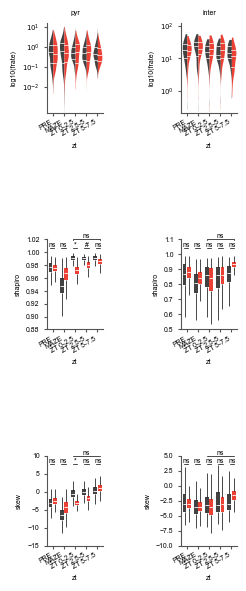

In [2]:
fig = subjects.SdFig().fig2()

palette = subjects.colors_sd(1)

boot_stat_df = grpdata.frate_normality_statistic_blocks_bootstrap
frate_df = subjects.GroupData().frate_post_chunks
frate_df.insert(6, "log10(frate)", np.log10(frate_df.frate.values))

for i, (ntype, ylims, yticks) in enumerate(zip(["pyr", "inter"], [(-3.3, 1.2), (-0.7, 2.1)], [(-2, -1, 0, 1), (0, 1, 2)])):
    ntype_df = frate_df[frate_df.neuron_type == ntype]
    boot_df = boot_stat_df[boot_stat_df.neuron_type == ntype]
    
    ax = fig.subplot(fig.gs[i*2])

    print(f"{ntype} status below:")
    plotter = Plotter(data=ntype_df, x="zt", y="log10(frate)", hue="grp", ax=ax)
    plotter.violinplot_sd(split=True, palette=palette).stat_anot_sd(
        stat_across=None,
        alpha_across=[0.05, 0.01, 0.001],
        fontsize=5,
    )
    ax.set_title(ntype)
    ax.set_ylim(ylims)
    ax.set_yticks(yticks)
    ax.set_yticklabels([f"$10^{{{ytick}}}$" for ytick in yticks])

    axboot = fig.subplot(fig.gs[2, i*2])
    bootplotter = Plotter(data=boot_df, x="zt", y="shapiro", hue="grp", ax=axboot)
    bootplotter.boxplot_sd(palette=palette).stat_anot_sd(
        stat_across=get_bootstrap_prob,
        alpha_across=[0.05, 0.01, 0.001],
        fontsize=5,
        verbose=True,
    )

    axboot_skew = fig.subplot(fig.gs[4, i*2])
    bootplotter_skew = Plotter(data=boot_df, x="zt", y="skew", hue="grp", ax=axboot_skew)
    bootplotter_skew.boxplot_sd(palette=palette).stat_anot_sd(
        stat_across=get_bootstrap_prob,
        alpha_across=[0.05, 0.01, 0.001],
        fontsize=5,
        verbose=True,
    )
    

# Calculate probabilities and add by hand to plots.  See block at bottom for p-value calculation logic.
alpha = 0.05
boot_prob_func = lambda x: np.sum(x > alpha)/len(x)
boot_stat_swp = (boot_stat_df.drop(labels=["shapiro", "skew", "iqr"], axis=1)
                .groupby(["neuron_type", "zt", "grp"])
                .apply(boot_prob_func)
                .reset_index()
               )
boot_stat_swp.to_csv(subjects.GroupData().path / "shapiro_bootstrap_binary_pvalues.csv")

fig.savefig(subjects.figpath_sd / "fig2_frate_dist.pdf")
fig.savefig(subjects.figpath_sd / "fig2_frate_dist", format="svg")
boot_stat_swp

#### Within ripple

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: p <= 1.00e-03

MAZE_NSD vs. MAZE_SD: get_bootstrap_prob, P_val:4.290e-01 Stat=2.956e-01
PRE_NSD vs. PRE_SD: get_bootstrap_prob, P_val:3.169e-01 Stat=5.802e-01
ZT 0-2.5_NSD vs. ZT 0-2.5_SD: get_bootstrap_prob, P_val:1.157e-01 Stat=1.581e+00
ZT 2.5-5_NSD vs. ZT 2.5-5_SD: get_bootstrap_prob, P_val:6.519e-02 Stat=2.046e+00
ZT 5-7.5_NSD vs. ZT 5-7.5_SD: get_bootstrap_prob, P_val:2.154e-01 Stat=1.007e+00
ZT 0-2.5_NSD vs. ZT 5-7.5_SD: get_bootstrap_prob, P_val:4.351e-01 Stat=1.710e-02
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: p <= 1.00e-03

MAZE_NSD vs. MAZE_SD: get_bootstrap_prob, P_val:3.513e-01 Stat=6.295e-01
PRE_NSD vs. PRE_SD: get_bootstrap_prob, P_val:3.406e-01 Stat=5.419e-01
ZT 0-2.5_NSD vs. ZT 0-2.5_SD: get_bootstrap_prob, P_val:3.708e-01 Stat=4.5

,neuron_type,zt,grp,shapiro_pvalue
0,inter,MAZE,NSD,0.0153
1,inter,MAZE,SD,0.0152
2,inter,PRE,NSD,0.0024
3,inter,PRE,SD,0.0154
4,inter,ZT 0-2.5,NSD,0.0125
5,inter,ZT 0-2.5,SD,0.0241
6,inter,ZT 2.5-5,NSD,0.0006
7,inter,ZT 2.5-5,SD,0.0219
8,inter,ZT 5-7.5,NSD,0.0004
9,inter,ZT 5-7.5,SD,0.0125


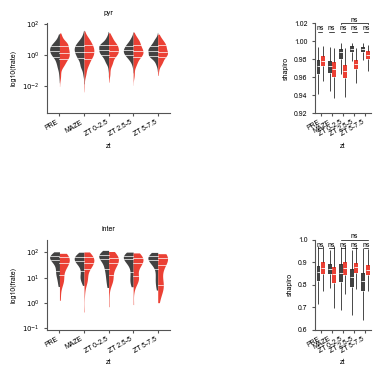

In [4]:
fig = subjects.SdFig().fig2()

palette = subjects.colors_sd(1)

boot_stat_df = grpdata.frate_win_ripple_normality_statistic_blocks_bootstrap
frate_df_sess = grpdata.frate_in_ripple
frate_df_sess = frate_df_sess[frate_df_sess["where"] == "inside"]
frate_df_sess = frate_df_sess.loc[(frate_df_sess!=0).all(axis=1)] # Drop any cells that have a 0 firing rate at any point
frate_df_sess.insert(6, "log10(frate)", np.log10(frate_df_sess.frate.values))


for i, (ntype, ylims, yticks) in enumerate(zip(["pyr", "inter"], [(-3.8, 2.05), (-1.05, 2.5)], [(-2, 0, 2), (-1, 0, 1, 2)])):
    ntype_df = frate_df_sess[frate_df_sess.neuron_type == ntype]
    boot_df = boot_stat_df[boot_stat_df.neuron_type == ntype]

    ax = fig.subplot(fig.gs[i*2, :2])

    plotter = Plotter(data=ntype_df, x="zt", y="log10(frate)", hue="grp", ax=ax)
    plotter.violinplot_sd(split=True, palette=palette).stat_anot_sd(
        stat_across=None,
        alpha_across=[0.05, 0.01, 0.005],
        fontsize=5,
    )
    ax.set_title(ntype)
    ax.set_ylim(ylims)
    ax.set_yticks(yticks)
    ax.set_yticklabels([f"$10^{{{ytick}}}$" for ytick in yticks])

    axboot = fig.subplot(fig.gs[i*2, 4])
    bootplotter = Plotter(data=boot_df, x="zt", y="shapiro", hue="grp", ax=axboot)
    bootplotter.boxplot_sd(palette=palette).stat_anot_sd(
        stat_across=get_bootstrap_prob,
        alpha_across=[0.05, 0.01, 0.001],
        fontsize=5,
        verbose=True,
    )

# Calculate probabilities and add by hand to plots.  See block at bottom for p-value calculation logic.
alpha = 0.05
boot_prob_func = lambda x: np.sum(x > alpha)/len(x)
boot_stat_swp = (boot_stat_df.drop(labels=["shapiro", "skew", "skew_pvalue", "iqr"], axis=1)
                .groupby(["neuron_type", "zt", "grp"])
                .apply(boot_prob_func)
                .reset_index()
               )
boot_stat_swp.to_csv(subjects.GroupData().path / "shapiro_win_ripple_bootstrap_binary_pvalues.csv")

fig.savefig(subjects.figpath_sd / "fig2_frate_win_ripple_dist.pdf")
fig.savefig(subjects.figpath_sd / "fig2_frate_win_ripple_dist", format="svg")
boot_stat_swp

## Shapiro-Wilk plots for deviations from log-normal distribution of firing rates
Bootstrap statistic distributions at each time epoch + pvalue distributions with session means overlaid (plot but don't include in figure).

In [ ]:
boot_stat_df = grpdata.frate_normality_statistic_blocks_bootstrap
palette = subjects.colors_sd(1)
palette_light = subjects.colors_sd_light(1)

frate_stat_df = grpdata.frate_normality_statistic_blocks_pyr_only

fig = subjects.SdFig().fig2_supp()

for ntype in ["pyr"]:
    boot_df = boot_stat_df[boot_stat_df.neuron_type == ntype]
    sess_df = frate_stat_df
    for n, stat_plot in enumerate(["shapiro", "shapiro_pvalue"]):
        ax = fig.subplot(fig.gs[n*2])
        p1 = Plotter(
            data=boot_df,
            x="zt",
            y=stat_plot,
            hue="grp",
            hue_order=["NSD", "SD"],
            ax=ax,
        )
        # ax.axhline(0.05, lw=0.5)
        # p1.plot_kw['fill'] = False
        # p1.boxplot_sd(palette=subjects.colors_sd(), box_fill=False)
        p1.boxplot_sd2(palette=palette)
        p1.stat_anot_sd(stat_across=None, alpha_across=0.025, fontsize=5, verbose=True)
    
        p2 = Plotter(data=frate_stat_df, x="zt", y=stat_plot, hue="grp", hue_order=["NSD", "SD"], ax=ax)
        p2.striplineplot_sd(palette=palette_light)
        if stat_plot == "shapiro_pvalue":
            ax.set_yscale("log")
            # ax.invert_yaxis(True)

fig.savefig(subjects.figpath_sd / "frate_shapiro_wilks_tests_pyr_only", format="pdf")

In [ ]:
# plot with combined mean overlaid
boot_stat_df = grpdata.frate_normality_statistic_blocks_bootstrap
palette = subjects.colors_sd(1)
palette_light = subjects.colors_sd_light(1)

# frate_stat_df = grpdata.frate_normality_statistic_blocks_pyr_only
sw_stat_df = pd.read_csv(subjects.GroupData().path / "shapiro_pvalues_raw.csv")

fig = subjects.SdFig().fig2_supp()

for ntype in ["pyr"]:
    boot_df = boot_stat_df[boot_stat_df.neuron_type == ntype]
    sess_df = sw_stat_df[sw_stat_df.neuron_type == ntype]
    for n, stat_plot in enumerate(["shapiro_pvalue"]):
        ax = fig.subplot(fig.gs[n*2])
        p1 = Plotter(
            data=boot_df,
            x="zt",
            y=stat_plot,
            hue="grp",
            hue_order=["NSD", "SD"],
            ax=ax,
        )
        # ax.axhline(0.05, lw=0.5)
        # p1.plot_kw['fill'] = False
        # p1.boxplot_sd(palette=subjects.colors_sd(), box_fill=False)
        p1.boxplot_sd2(palette=palette)
        p1.stat_anot_sd(stat_across=None, alpha_across=0.025, fontsize=5, verbose=True)
    
        p2 = Plotter(data=sess_df, x="zt", y=stat_plot, hue="grp", hue_order=["NSD", "SD"], ax=ax)
        p2.striplineplot_sd(palette=palette_light)
        if stat_plot == "shapiro_pvalue":
            ax.set_yscale("log")
            # ax.invert_yaxis(True)
        ax.axhline(0.05, color='k', linestyle='--', linewidth=0.5)

fig.savefig(subjects.figpath_sd / "frate_shapiro_wilks_tests_pyr_only_w_raw_value", format="pdf")

### Example plots to understand bootstrapped Shapiro-Wilk p-value calculations
***Logic***: generate 10000 gaussian distributions with the same mean and std of the data and calculate S-W p-value and examine the distribution. Should we calculate the p-value of the boostrapped data by **A)** averaging the boostrapped p-value or **B)** by thresholding at alpha and calculating the propotion of bootstrap p-values that exceed alpha?  

***Answer:*** Method B. Method A returns an average p-value of 0.5, which is not equal to alpha.  Method B returns a p-value of ~0.95, which is congruous with alpha = 0.05.

In [ ]:
# Plot NSD RS1 bootstrap distribution with original p-value overlaid
ntype, grp, zt = "pyr", "NSD", "2.5-5"
alpha = 0.05
boot_df_use = boot_stat_df[(boot_stat_df.neuron_type == ntype) & (boot_stat_df.grp == grp) & (boot_stat_df.zt == zt)]
raw_df = subjects.GroupData().frate_post_chunks
raw_df_use = raw_df[(raw_df.neuron_type == ntype) & (raw_df.grp == grp) & (raw_df.zt == zt)]
raw_df_use.insert(6, 'log(frate)', np.log(raw_df_use.frate.values))
_, ax = plt.subplots(2, 2, figsize=(12, 6))
for a, log_bool in zip(ax[0], [False, True]):
    sns.histplot(boot_df_use.shapiro_pvalue, bins=50, ax=a, log_scale=log_bool)
    hl1 = a.axvline(sw_stat_df[(sw_stat_df.neuron_type == ntype) & (sw_stat_df.grp == grp) & (sw_stat_df.zt == zt)].shapiro_pvalue.values,
             color='r')
    hl2 = a.axvline(alpha, color='k', linestyle='--')
    a.set_title(f'Bootstrapped S-W p-values for {ntype} {grp} {zt} session')
    a.legend((hl1, hl2), ('raw p-value', f"p={alpha}"))

print(f"\n\033[4mShapiro-Wilk p-value from raw distribution w/o bootstrapping = {stats.shapiro(raw_df_use['log(frate)'].values)[1]:0.3g}\033[0m")
print(f"Method A: Mean Shapiro-Wilk p-value from bootstraps = {np.mean(nsd_rs1_pyr.shapiro_pvalue.values):0.3g}")
print(f"Method B: Probability bootstrapped Shapiro-Wilk p > {alpha}: {np.sum(nsd_rs1_pyr.shapiro_pvalue > alpha)/nsd_rs1_pyr.shape[0]:0.3g}\n")

# Generate null distributions from a gaussian with the same mean and standard deviation as the session above. Plot p-value distribution
# and calculate p-value by method A vs. B.
nboot = 10000
pval_normal_boot = []
raw_mean, raw_std = np.mean(raw_df_use["log(frate)"]), np.std(raw_df_use["log(frate)"])
for i in range(nboot):
    sim_frs = raw_mean + raw_std*np.random.randn(raw_df_use.shape[0])
    pval_normal_boot.append(stats.shapiro(sim_frs)[1])

for a, log_bool in zip(ax[1], [False, True]):
    sns.histplot(pval_normal_boot, bins=50, ax=a, log_scale=log_bool)
    # hl1 = a.axvline(sw_stat_df[(sw_stat_df.neuron_type == ntype) & (sw_stat_df.grp == grp) & (sw_stat_df.zt == zt)].shapiro_pvalue.values,
             # color='r')
    hl2 = a.axvline(alpha, color='k', linestyle='--')
    a.set_title(f'Simulated Gaussian Data w/same mean & std as above')
    a.legend((hl2,), (f"p={alpha}",))

print(f"Method A: Mean Shapiro-Wilk p-value from bootstraps = {np.mean(pval_normal_boot):0.3g}")
print(f"Method B: Probability boostrapped Gaussian Shapiro-Wilk p > {alpha}: {np.sum(np.array(pval_normal_boot) > alpha)/len(pval_normal_boot):0.3g}")

### saving

In [ ]:
fig.savefig(filename)